# Digit & Alphabet recognization

### 1. Read Image Data 
>1. Read folders path into a list
>2. Read each image from previous folder path list 
>3. set the mean pixel value as threshold and transfer the image to Black&White
>4. Flatten the image data into a dataframe
>5. Read Good images
>6. Read bad images

### 2. Data preparation
>1. Normalization & Encoding
>2. Reshape it especially for Keras

### 3. SVM & CNNs Modeling
>1. SVM & Params tuning
>2. CNNs & Params tuning
>3. Evaluate models


In [127]:
# This is a use case for image recognition. The primary goal is to recognize the letters from 0-9, A-Z and a-z. The dataset for the same is available @ http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/. Download the english character images ( 64 classes in all ) from the website.

# Following is the problem statement.
# Given an image representing a character in the english design and implement a recognizer and predictor for the images.

# Understanding the problem statement, the goal for the session is to identify the Following

# 1. What is this problem type?
# 2. How do we read data from images?
# 3. What are the steps involved in preparing the data for modeling.
# 4. What kind of models would you chose to implement?
# 5. What is model tuning?

# Keep in mind that every approach does not have to follow the same steps, a sample implementation is provided below for working with digits from 0-9. You can extend this for all 64 classes and try it out yourself or otherwise implement the model by yourself and present a solution.

# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from PIL import Image
from statistics import mean
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV 
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.metrics import categorical_accuracy

# Importing the metrics we are going to be using to measure the results of the model.
from sklearn.metrics import accuracy_score

# The following statement is only applicable if you are running this test in juptyer notebook or Atom text editor with hydrogen plugin installed.
%matplotlib inline

In [2]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau
from keras.layers.convolutional import Convolution2D

/Users/senquan.chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Read Image Data

>### Set the mean pixel value as threshold and transfer the image to Black&White

In [3]:
# The following function is a threshold calculator which calculates the mean for each pixel 
#and if the pixel value is greater than the threshold then assigns it white color and if 
#less than the mean then black. Primarily it is coverting multi color images to binary color images.
def threshold(imageArray):
    balanceAr = []
    
    for eachRow in imageArray:
        for eachPix in eachRow:
            avgNum = mean(eachPix[:3])
            balanceAr.append(avgNum)
    balance = mean(balanceAr)

    newMat = []
    for eachRow in imageArray:
        newRow = []
        for eachPix in eachRow:
            if mean(eachPix[:3]) > balance:
                newRow.append(255)
#                 newRow.apend((eachPix[:0]*(0.6) +... ))
            else:
                newRow.append(0)
        newMat.append(newRow)
        
    return np.array(newMat)

>### Read folders path into a list

In [4]:
# Although image imports can be automated using 'os' package, the following function 
# semi-automates it as it is processing the image each time it is imported.
def folderLoader(basePath, nextPath, sampleSize, section2, imageFormat): 
    listFiles = []
    target = []
    for i in range(1,sampleSize + 1):
        target_value = i - 1
        numAferSample = ''
        if i < 10:
            numAfterSample = '00' + str(i)
        elif i < 100:
            numAfterSample = '0' + str(i)
                
        nextPath_temp = nextPath + numAfterSample
        section2_temp = section2 + numAfterSample + '-'
        
        index = 1
        filePath = basePath + nextPath_temp + section2_temp + '0000' + str(index) + imageFormat
        while Path(filePath).exists():
            target.append(target_value) #append target value for each pic
            listFiles.append(filePath)
            index = index + 1
            if index < 10:
                filePath = basePath + nextPath_temp + section2_temp + '0000' + str(index) + imageFormat
            elif index < 100:
                filePath = basePath + nextPath_temp + section2_temp + '000' + str(index) + imageFormat
            elif index < 1000:
                filePath = basePath + nextPath_temp + section2_temp + '00' + str(index) + imageFormat

    return listFiles, target

>### Flatten the image data into a dataframe

In [5]:
def loadImageData(pathList, target):
    finalList = []
    for path in pathList:
        im = Image.open(path, 'r')
        resizedIm = im.resize([28,28])
        image = np.asarray(resizedIm)
        imageThreshold = threshold(image)
        imageRow = imageThreshold.flatten()
        finalList.append(imageRow)
    df = pd.DataFrame(finalList)
    df['class'] = target
    return df

In [6]:
# The following section is where each folder is being traversed and the functions 
# defined above are being called to get the data sourced.
df = pd.DataFrame()
basePath = '/Users/senquan.chen/Downloads/English/Img'
goodPath = '/GoodImg/Bmp/Sample'
badPath = '/BadImag/Bmp/Sample'
sampleSize = 62
sec2 = '/img'
form = '.png'

>### Read Good images

In [7]:
pathlist,target = folderLoader(basePath, goodPath, sampleSize, sec2, form)

In [81]:
pathlist[:5]

['/Users/senquan.chen/Downloads/English/Img/GoodImg/Bmp/Sample001/img001-00001.png',
 '/Users/senquan.chen/Downloads/English/Img/GoodImg/Bmp/Sample001/img001-00002.png',
 '/Users/senquan.chen/Downloads/English/Img/GoodImg/Bmp/Sample001/img001-00003.png',
 '/Users/senquan.chen/Downloads/English/Img/GoodImg/Bmp/Sample001/img001-00004.png',
 '/Users/senquan.chen/Downloads/English/Img/GoodImg/Bmp/Sample001/img001-00005.png']

In [8]:
dfin = loadImageData(pathlist,target)

In [9]:
print('The shape of good images is ',dfin.shape)
dfin.head()

The shape of good images is  (7659, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,class
0,255,255,255,255,255,255,255,255,255,0,...,255,255,255,255,255,255,255,255,255,0
1,255,255,0,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0


>### Read bad images

In [10]:
badpathlist, target = folderLoader(basePath, badPath, sampleSize, sec2, form)

In [82]:
badpathlist[:5]

['/Users/senquan.chen/Downloads/English/Img/BadImag/Bmp/Sample001/img001-00001.png',
 '/Users/senquan.chen/Downloads/English/Img/BadImag/Bmp/Sample001/img001-00002.png',
 '/Users/senquan.chen/Downloads/English/Img/BadImag/Bmp/Sample001/img001-00003.png',
 '/Users/senquan.chen/Downloads/English/Img/BadImag/Bmp/Sample001/img001-00004.png',
 '/Users/senquan.chen/Downloads/English/Img/BadImag/Bmp/Sample001/img001-00005.png']

In [11]:
dfin_bad = loadImageData(badpathlist,target)

In [12]:
print('the shape of bad images is ',dfin_bad.shape)
dfin_bad.head()

the shape of bad images is  (4798, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,class
0,0,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,255,255,255,255,0


# 2. Data preparation

In [13]:
df = dfin.append(dfin_bad)

print('There are total {} images'.format(df.shape[0]))
df.head()

There are total 12457 images


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,class
0,255,255,255,255,255,255,255,255,255,0,...,255,255,255,255,255,255,255,255,255,0
1,255,255,0,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0


In [14]:
train_df = df.copy()

>### Data spliting & Normalization

In [15]:
X = train_df.drop('class', axis = 1)
y = train_df['class']

X.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255,255,255,255,255,255,255,255,255,0,...,255,255,255,255,255,255,255,255,255,255
1,255,255,0,255,255,255,255,255,255,255,...,0,255,255,255,255,255,255,255,255,255
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [16]:
X = X/255.0

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state= 110) # Set random_state

>### Reshape, prepare for using Keras

In [17]:
# Data normalization for CNNs
X_train_cnns = X_train.values.reshape(-1,28,28,1)
X_val_cnns = X_val.values.reshape(-1,28,28,1)

y_train_cnns = to_categorical(y_train, 62)
y_val_cnns = to_categorical(y_val, 62)

>### Photo review

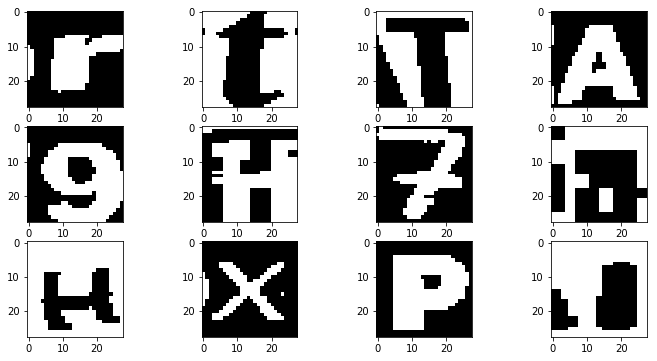

In [18]:
plt.figure(figsize=(12,6))
y_axis, x_axis = 3, 4
for i in range(y_axis*x_axis):
    plt.subplot(y_axis, x_axis, i+1)
    rand = np.random.randint(0, X_train_cnns.shape[0],1)
    img = np.reshape(X_train_cnns[rand],(28,28))
    plt.imshow(img, cmap = 'gray')
plt.show()

# SVM & CNNs Modeling 

>### SVM & Params tuning

In [97]:
scaler= StandardScaler()

In [98]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [99]:
svc_clf = SVC()
kfold = KFold(n_splits=5)
cross_val_score(svc_clf, X_train_scaled, y_train, cv=kfold, n_jobs=-1)

array([0.60633081, 0.60214095, 0.61418376, 0.62667261, 0.60704728])

In [100]:
Cs = np.logspace(-1,6,5,10,15)
clf = GridSearchCV(estimator=svc_clf, param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([6.66667e-02, 7.62199e+00, 8.71421e+02, 9.96295e+04, 1.13906e+07])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
clf.best_score_

0.6028008206226028

In [102]:
clf.best_estimator_

SVC(C=7.621991222319221, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [103]:
svc_clf = SVC(C=7.622)
svc_clf.fit(X_train, y_train)

SVC(C=7.622, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [104]:
print("SVC classifier accuracy score is: ",accuracy_score(svc_clf.predict(X_val_scaled), y_val))

SVC classifier accuracy score is:  0.651685393258427


>># Since the dataset is huge, it takes a lot of time to tune. I tuned once and  the maximum accuracy is about 65%. 

>### CNNs & Params tuning

In [48]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(62, activation = "softmax"))

In [49]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [50]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [51]:
cnnsModel = model.fit(X_train_cnns, y_train_cnns, batch_size = 90, epochs = 30, validation_data = (X_val_cnns, y_val_cnns))

Train on 11211 samples, validate on 1246 samples
Epoch 1/30
11211/11211 [==============================] - 24s 2ms/step - loss: 3.3806 - acc: 0.1915 - val_loss: 2.3979 - val_acc: 0.3868
Epoch 2/30
11211/11211 [==============================] - 24s 2ms/step - loss: 2.1686 - acc: 0.4485 - val_loss: 1.6053 - val_acc: 0.5923
Epoch 3/30
11211/11211 [==============================] - 24s 2ms/step - loss: 1.6711 - acc: 0.5576 - val_loss: 1.3703 - val_acc: 0.6244
Epoch 4/30
11211/11211 [==============================] - 24s 2ms/step - loss: 1.4168 - acc: 0.6127 - val_loss: 1.1820 - val_acc: 0.6870
Epoch 5/30
11211/11211 [==============================] - 24s 2ms/step - loss: 1.2683 - acc: 0.6477 - val_loss: 1.0893 - val_acc: 0.6870
Epoch 6/30
11211/11211 [==============================] - 24s 2ms/step - loss: 1.1383 - acc: 0.6777 - val_loss: 1.0213 - val_acc: 0.7127
Epoch 7/30
11211/11211 [==============================] - 24s 2ms/step - loss: 1.0520 - acc: 0.7015 - val_loss: 1.0085 - val_acc:

>># The CNNs model accuracy is about 77% which is about 12% over than SVM mode.

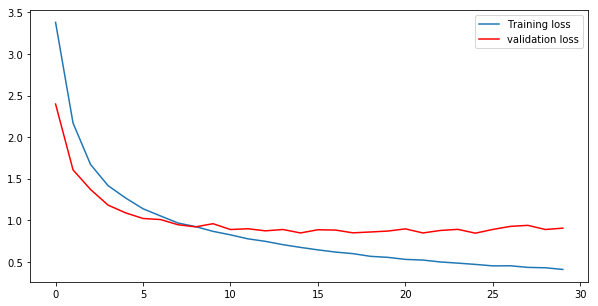

In [79]:
plt.figure(figsize=(10,5))
plt.plot(cnnsModel.history['loss'], label="Training loss")
plt.plot(cnnsModel.history['val_loss'], color='r', label="validation loss")
legend = plt.legend(loc='best')

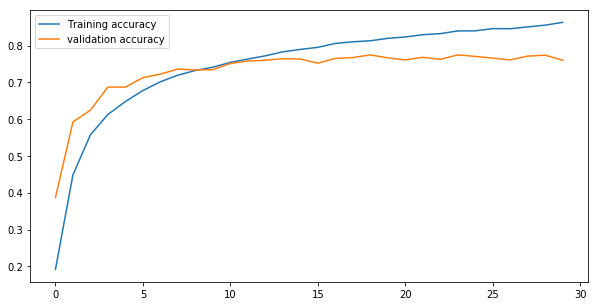

In [80]:
plt.figure(figsize=(10,5))
plt.plot(cnnsModel.history['acc'], label="Training accuracy")
plt.plot(cnnsModel.history['val_acc'], label="validation accuracy")
legend = plt.legend(loc='best')

># Testing

In [84]:
test_basePath = '/Users/senquan.chen/Desktop/TestingImage'
next_Path = '/Sample'
sampleSize = 62
sec2 = '/img'
form = '.png'

In [89]:
test_filePath, test_target = folderLoader(test_basePath, next_Path, sampleSize, sec2, form)

In [158]:
test_df = loadImageData(test_filePath,test_target)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,class
0,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,255,255,255,255,0
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0


In [159]:
test_df = test_df.sample(test_df.shape[0], random_state=2)

In [160]:
X_test = test_df.drop('class', axis = 1)
y_test = test_df['class']

In [161]:
X_test = X_test/255.0

In [162]:
X_test_scaled = scaler.fit_transform(X_test)

In [163]:
X_test_cnns = X_test.values.reshape(-1,28,28,1)
y_test_cnns = to_categorical(y_test, 62)

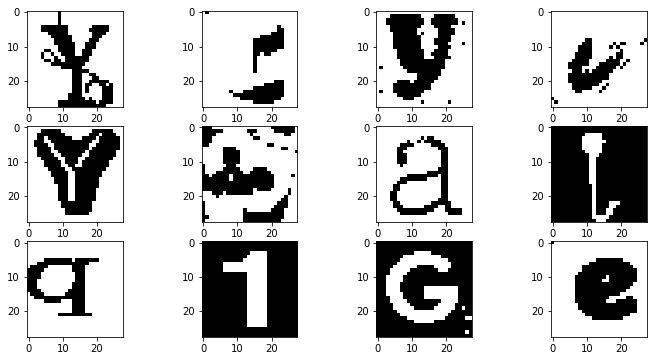

In [164]:
plt.figure(figsize=(12,6))
y_axis, x_axis = 3, 4
for i in range(y_axis*x_axis):
    plt.subplot(y_axis, x_axis, i+1)
    rand = np.random.randint(0, X_test_cnns.shape[0],1)
    img = np.reshape(X_test_cnns[rand],(28,28))
    plt.imshow(img, cmap = 'gray')
plt.show()

>## SVM MODEL TESTING

In [178]:
print('The accuracy of SVM model for testing image is {:.3f}'.format(accuracy_score(svc_clf.predict(X_test_scaled), y_test)))

The accuracy of SVM model for testing image is 0.140


>## CNNs MODEL TESTING

In [179]:
y_test_pred = model.predict_classes(X_test_cnns)
print('The accuracy of SVM model for testing image is {:.3f}'.format(accuracy_score(y_test_pred,y_test)))

The accuracy of SVM model for testing image is 0.508


In [180]:
list(zip(y_test_pred, y_test))[:10]

[(10, 4),
 (44, 7),
 (13, 58),
 (8, 8),
 (10, 10),
 (4, 4),
 (23, 23),
 (60, 60),
 (37, 37),
 (9, 14)]

>> ## It's weird that the texting dataset is only 50% accuracy.  Thoughts: 
>>> 1. I doubt it might be the problem of default threshold from keras 'predict_classes' function. I need to check more info about the predicition funciton. 

>>> 2. The image i collect might be too bad for the model. (not that possible)

>>> 3. since images only with black and white pixels give very blury result as we can see from image preview. I think it might be better to use grey scale or keep tuning the model like filters.